# [A3] Principal Component Analysis (PCA) 

In this exercise, the concept of **dimensionality reduction** is introduced by performing a principal components analysis (PCA). Principal components regression (PCR) is introduced as an application of PCA.

## 1: What is PCA?
The goal of PCA is to identify patterns in data by exploring the correlation between variables. If variables are strongly correlated, the dimensionality of a problem can be reduced using PCA: in simple terms, two or more features of a dataset can be combined into a fewer number of features that are calculated using the PCA. 

The idea is to identify the directions with maximum variance (eigenvectors) in high $d$-dimensional data and project the data to a smaller ($k$)-dimensional subspace ($k < d$) while retaining most of the information.

A summary of the PCA approach:
1. Standardize the dataset
2. Determining eigenvectors and eigenvalues using covariance matrix. 
3. Sorting eigenvalues in descending order and selecting $k$ eigenvectors corresponding to the $k$ largest eigenvalues.
4. Constructing a projection matrix $W$ from the selected $k$ eigenvectors.
5. Transforming the original data set X over W to obtain a $k$-dimensional feature subspace $Y$.

 
## 2: Applying PCA to the IRIS dataset
To provide a practical understanding of PCA, the concept is implemented below using the IRIS dataset (which was introduced in the first exercise).

### 2.1: Preprocessing: Import & Visualization & Standardization
As usual, we start by importing and then splitting the data into features ($X$) and labels ($y$).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


iris_data = pd.read_csv(
    "data/iris.data",
    header=None,
    sep=",",
    names=["sepal_length", "sepal_width", "petal_length", "petal_width", "class"],
)



display(iris_data.head(2))


,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa


The distribution of the feature values for each of the 3 different flower classes can be visualized via histograms:

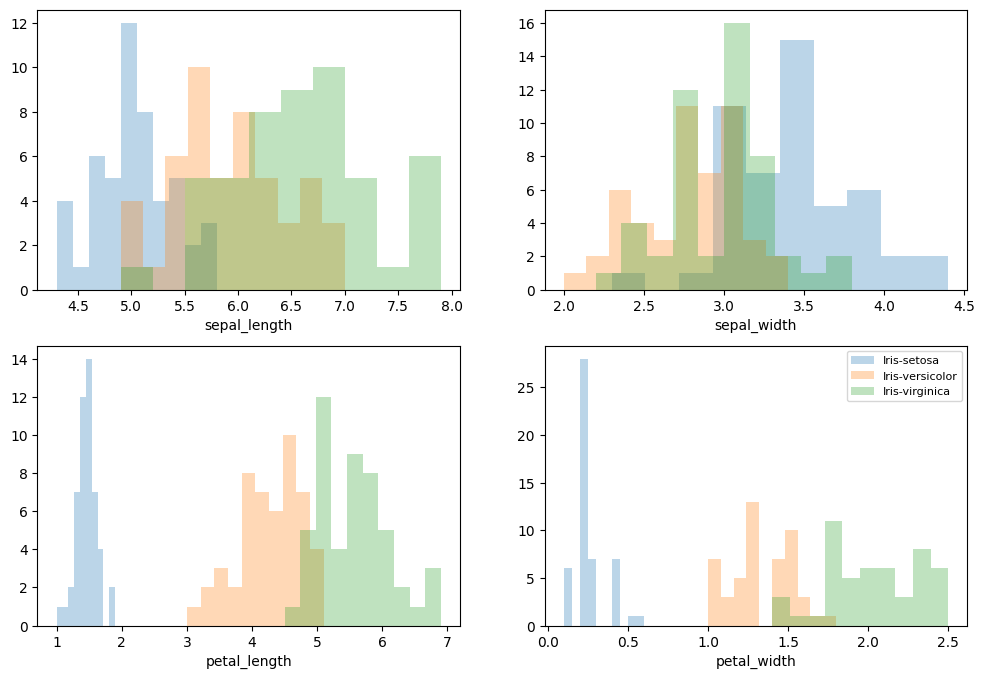

In [2]:
plt.figure(figsize=(12, 8))
for colid, colname in enumerate(iris_data.columns[:-1]):
    plt.subplot(2, 2, colid + 1)
    for lab in iris_data["class"].unique():
        plt.hist(
            iris_data.iloc[:, 0:4].values[iris_data['class'] == lab, colid],
            label=lab,
            bins=10,
            alpha=0.3,
        )
    plt.xlabel(colname)
plt.legend(loc="upper right", fancybox=True, fontsize=8)

plt.show()


Plot pairwise relationships:

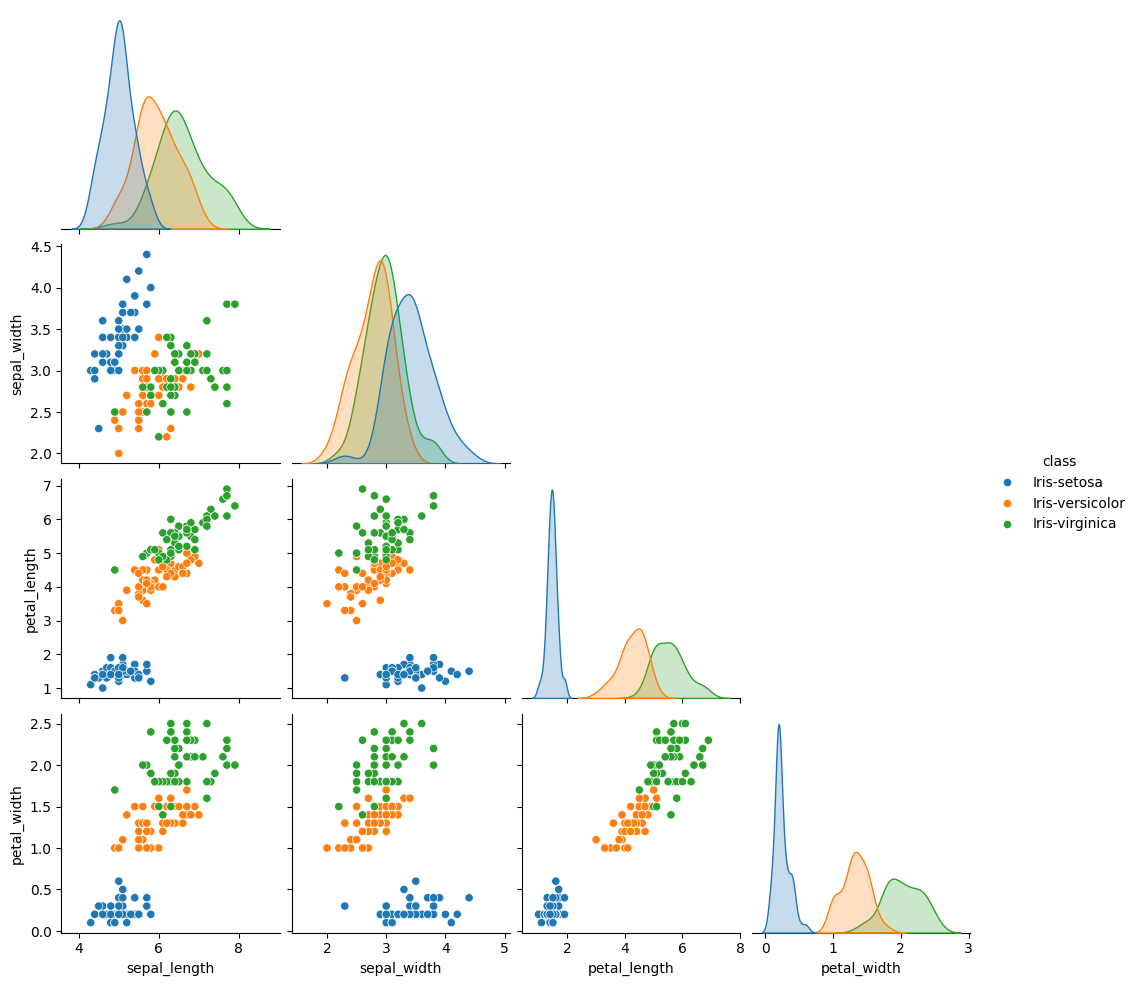

In [3]:
# Convert 'class' to a categorical type for better color handling
iris_data['class'] = iris_data['class'].astype('category')

# Create a pairplot
sns.pairplot(iris_data, hue='class', corner=True)
plt.show()

Obviously each of these six 2D plots shows only a small part of the information. Can we make a 2D plot which captures most of the information?

In [4]:
# split data table into data X and class labels y
iris_X = iris_data.iloc[:, 0:4].values
iris_y = iris_data.iloc[:, 4].values

#### Data Standardization

In [5]:
# 1. Data Standardization
std_scale = StandardScaler()
iris_X_std = std_scale.fit_transform(iris_X)

### 2.2: ✏️ The covariance matrix


1. Determine the covariance matrix of the standardized data:
<br>
   Note: numpy requires you to transpose your X values first, as it expects each object to be represented as a column.


In [6]:
# TODO: Implement
trans_mat = iris_X_std.transpose()
cov_mat = np.cov(trans_mat)
print("covariance matrix:\n", cov_mat)

covariance matrix:
 [[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


### 2.3: Eigendecomposition - Calculation of eigenvectors and eigenvalues
Given the covariance matrix, we can now perform an eigendecomposition of it, providing both

- the eigenvectors (principal components) that determine the directions of the new feature space and
- the eigenvalues that determine the magnitude/size (they explain the variance of the data along the new feature axes).

#### 2.3: ✏️ Eigenvalues and Eigenvectors



1. Determine the eigenvectors and the eigenvalues:
<br>

   ** Note: For using np.linalg.eig to determine the eigenvalues and the eigenvectors: eigenvectors, such that **the column** eigenvectors[ : , i ] is the eigenvector corresponding to the eigenvalue eigenvalues[ i ]

In [7]:
# TODO: Implement
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print("Eigenvalues", eig_vals)
print("Eigenvectors\n", eig_vecs)


Eigenvalues [2.93035378 0.92740362 0.14834223 0.02074601]
Eigenvectors
 [[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]


### 2.4: Selecting Principal Components
As mentioned, the goal of the PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace.

In this subspace, the eigenvectors form the _axes_ of the coordinate system, or more precisely, their directions - as all eigenvectors have the same unit length of 1: 

In [8]:
for ev in eig_vecs.T:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print("Ok Ok!")


Ok Ok!


To reduce the number of dimensions (and _axes_) we need to reduce the number of eigenvectors.

To decide which eigenvector(s) can be dropped without losing too much information, the corresponding eigenvalues must be examined: 

The eigenvectors with the lowest eigenvalues contain the least information about the distribution of the data and can be dropped.


#### 2.4.1: Sorting the eigenpairs
1. Generate a list of tuples containing the eigenvalues and eigenvectors. Sort them based on eigenvalues from highest to lowest:

In [9]:

eig_pairs = [(eig_vals[i], eig_vecs[:, i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda pair: pair[0], reverse=True)

print("Eigenvalues (in descending order) and their eigenvectors:")
for i in eig_pairs:
    print(i[0], i[1])


Eigenvalues (in descending order) and their eigenvectors:
2.9303537755893165 [ 0.52237162 -0.26335492  0.58125401  0.56561105]
0.9274036215173417 [-0.37231836 -0.92555649 -0.02109478 -0.06541577]
0.14834222648163994 [-0.72101681  0.24203288  0.14089226  0.6338014 ]
0.020746013995596356 [ 0.26199559 -0.12413481 -0.80115427  0.52354627]


#### 2.4.2: Determining the best number of Principal Components (Explained Variance)
After sorting the eigenpairs, you may ask yourself how many principal components you should keep for the new feature subspace.
A useful measure is the so-called **explained variance**, which can be calculated from the eigenvalues, indicating how much information (variance) can be assigned to each principal component.

1. Determine the explained variance by calculating the percentage of each eigenvalue in the total sum of eigenvalues:

In [10]:
# TODO: Implement
print("eig_vals:", eig_vals)
tot = sum(eig_vals)
for i in range(len(eig_vals)):
    expl_var = (eig_vals[i] / tot) * 100
    print(f"variance that is explained by eigenvalue {i}: {expl_var}")


var_exp = [(i / tot) * 100 for i in sorted(eig_vals, reverse=True)]
print("var_exp:", var_exp)
cum_var_exp = np.cumsum(var_exp)


eig_vals: [2.93035378 0.92740362 0.14834223 0.02074601]
variance that is explained by eigenvalue 0: 72.77045209380132
variance that is explained by eigenvalue 1: 23.03052326768064
variance that is explained by eigenvalue 2: 3.68383195762739
variance that is explained by eigenvalue 3: 0.5151926808906425
var_exp: [72.77045209380132, 23.03052326768064, 3.68383195762739, 0.5151926808906425]


These results show that most (92.46%) of the variance can be explained by the first principal component alone. 

The second principal component still contains some information (5.30%), while the third and fourth principal components can be safely dropped without losing too much information. 

--> Together, the first two principal components contain 97.76% of the information ==> $k=2$

### 2.5: ✏️ Creating the Projection Matrix $W$
We can now construct the projection matrix used to transform the Iris data into the new ($k=2$, two-dimensional) feature subspace.

The projection matrix $W \in \R^{d\times k}$ contains the top-$k$ eigenvectors as columns (and is sometimes called _eigenvector matrix_).

1. Generate the projection matrix $W$ for $k=2$ from the sorted eigenpairs.

In [11]:
k = 2
# TODO: Implement
top_keigvec = np.array([eig_vecs for _, eig_vecs in eig_pairs[:k]])
W = top_keigvec.transpose()
print("Matrix W of shape (4, 2):\n", W)


Matrix W of shape (4, 2):
 [[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


### 2.6: ✏️ Projecting the data into the new feature subspace

In this final step, the $4 \times 2$-dimensional projection matrix W is used to transform the data $X$ to the new subspace.

Mathematically, this is a simple dot product: $\hat{X}=X \cdot W$ 

1. Use the projection matrix $W$ to transform the iris dataset (``iris_X_std``) to fewer dimensions and output the shape of the transformed dataset.

In [12]:
# TODO: Implement

iris_X_transformed = np.dot(iris_X_std, W)
print(iris_X_transformed.shape)

(150, 2)


### 2.7: Visualizing the projection
We have now reduced the four-dimensional feature space of the Iris dataset to two dimensions.

We can visualize these two dimensions using the following plot:

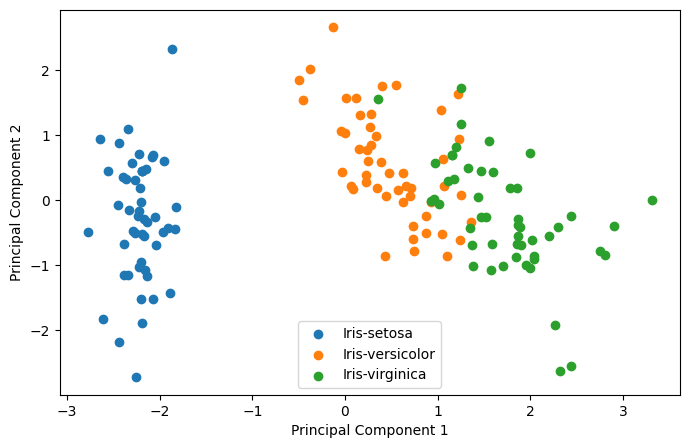

In [13]:
plt.figure(figsize=(8, 5))
for id, classname in enumerate(iris_data["class"].unique()):
    plt.scatter(
        iris_X_transformed[iris_y == classname, 0],
        iris_X_transformed[iris_y == classname, 1],
        label=classname,
        c=f"C{id}",
    )
plt.gca().update(dict(xlabel="Principal Component 1", ylabel="Principal Component 2"))
plt.legend(loc="lower center")
plt.show()


Ideally, for the three classes of flowers you should see three distinct (or at least well separable) clusters. 

### 2.8: PCA using scikit_learn

By using a pipeline that contains two steps: the first step is for data standardization, and the second step is for the PCA approach. The number of selected components is set to 2.

In [14]:
# Creating a pipeline 
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=2))
])

iris_tranformed_pca = pipeline.fit_transform(iris_X)

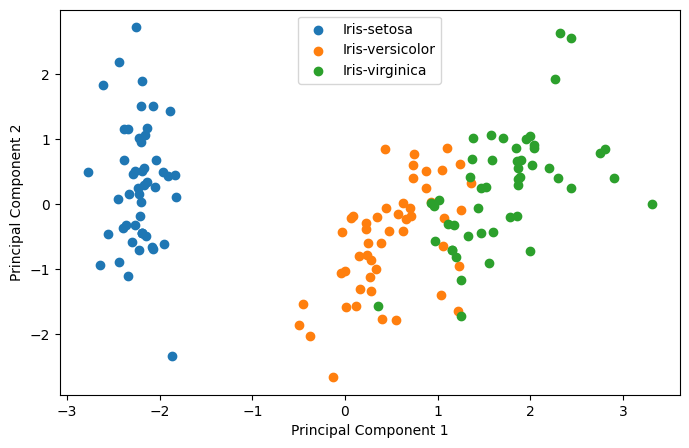

In [15]:
# Visualization
plt.figure(figsize=(8, 5))
for id, classname in enumerate(iris_data["class"].unique()):
    plt.scatter(
        iris_tranformed_pca[iris_y == classname, 0],
        iris_tranformed_pca[iris_y == classname, 1],
        label=classname,
        c=f"C{id}",
    )
plt.gca().update(dict(xlabel="Principal Component 1", ylabel="Principal Component 2"))
plt.legend(loc="upper center")
plt.show()


sum of the explained variance ratio by the frist and the second components: 0.9580097536148195


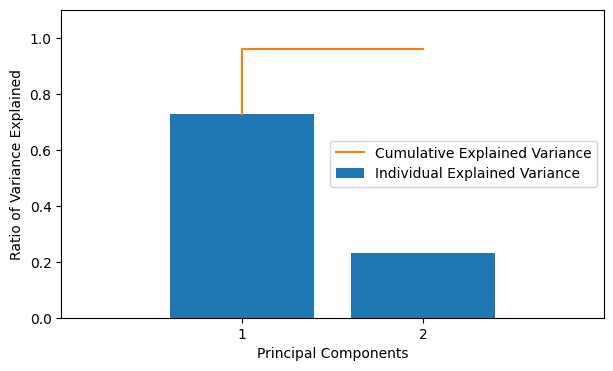

In [16]:
# Explained Variance
var_exp=pipeline[1].explained_variance_ratio_

Explained_Variance = pipeline[1].explained_variance_ratio_.sum()
print(f"sum of the explained variance ratio by the frist and the second components: {Explained_Variance}")

display
# Plot of Explained Variance
n = np.arange(1 , pipeline[1].n_components+1)
ax = plt.figure(1, figsize=(7, 4)).subplots(1, 1)
ax.bar(n, var_exp, label='Individual Explained Variance')
ax.step(n, np.cumsum(var_exp), 'C1', label='Cumulative Explained Variance')
ax.axis([0, 3, 0, 1.1])
ax.set_xticks(np.arange(1, 3))
ax.set_xlabel('Principal Components')
ax.set_ylabel(r'Ratio of Variance Explained')
ax.legend()

## 3: Applying PCR to Combined Cycle Power Plant (CCPP Dataset)

In Principal Components Regression (PCR), a subset of the principal components is used for regression. This makes PCR a kind of regularized procedure and also a type of shrinkage estimator. In this approach, the number of principal components in the selected subset is considered as a hyperparameter.
<br>
This hyperparameter is tuned based on the model performance over a validation set. The explained variance by the selected principal components should also be considered.

For this task, the CCPP dataset will be used. The dataset contains 9,568 data points collected from a Combined Cycle Power Plant over six years (2006-2011), when the power plant was set to operate at full load. It consists of four input variables—hourly average ambient variables: Temperature (T), Ambient Pressure (AP), Relative Humidity (RH), and Exhaust Vacuum (V)—to predict the net hourly electrical energy output (EP) of the plant (the target variable).

<br>
A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST), and heat recovery steam generators. In a CCPP, electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another.

<br>

For further information about this dataset, refer to the following published paper:
<br> 
http://www.sciencedirect.com/science/article/pii/S0142061514000908

### 3.1: Data Preparation


In [17]:
# Load the dataset
df = pd.read_csv("data/Folds5x2_pp.csv", sep=';')

display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


None

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


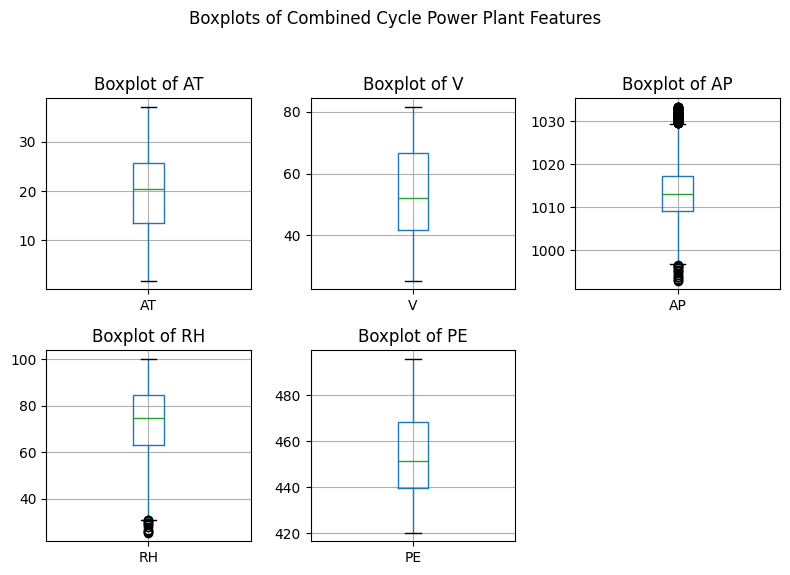

In [18]:
# Plotting boxplots to check for outliers
plt.figure(figsize=(8, 6))
plt.suptitle('Boxplots of Combined Cycle Power Plant Features', fontsize=12)

# List of column names for looping and plotting
columns = df.columns
for i, column in enumerate(columns):
    plt.subplot(2, 3, i + 1)  # Assuming there are 4 features, adjust subplot grid if different
    df.boxplot(column)
    plt.title(f'Boxplot of {column}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles and main title
plt.show()

In [19]:
# Function: Removing Outliers 
def remove_outliers(df):
    dfc = df.copy()
    upper_limits = dfc.quantile(0.995)
    lower_limits = dfc.quantile(0.005)
    for colname in dfc.columns:
        col = dfc[colname]
        dfc = dfc[
            ((col <= upper_limits[colname]) & (col >= lower_limits[colname]))
            | col.isna()
        ]
    return dfc

In [20]:
# Removing Outliers 
df=remove_outliers(df)
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9152 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9152 non-null   float64
 1   V       9152 non-null   float64
 2   AP      9152 non-null   float64
 3   RH      9152 non-null   float64
 4   PE      9152 non-null   float64
dtypes: float64(5)
memory usage: 429.0 KB


None

<Axes: >

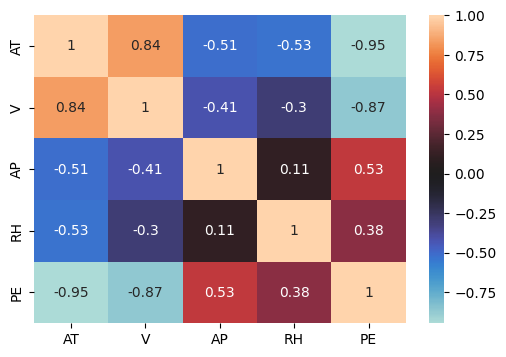

In [21]:
# Correlation Matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True,center=0)

In [22]:
# Extract the target and the input variables
y = df.pop('PE')
X = df

In [23]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


### 3.2: ✏️ Linear Regression

1. Fit a linear regression model using the sklearn pipeline.
<br>
"pipeline_1" has two steps: the first step is for data standardization, and the second step is for the learning algorithm (linear regression).
2. Evaluate the model on both the training data and test data.
3. Discuss the evaluation results considering the problems of overfitting and underfitting.

In [24]:
# Creating a pipeline 
pipeline_1 =Pipeline([('scaler', StandardScaler()),('regressor', LinearRegression())]) 

pipeline_1.fit(X_train, y_train)


# Evaluate the model on training data
y_train_pred = pipeline_1.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
mAe = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
print('Training')
print(f"RMSE: {np.sqrt(mse)}")
print(f"MAE: {mAe}")
print(f"R2 Score: {r2}")

# Evaluate the model on test data
y_test_pred = pipeline_1.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
mAe = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print('Test')
print(f"RMSE: {np.sqrt(mse)}")
print(f"MAE: {mAe}")
print(f"R2 Score: {r2}")

Training
RMSE: 4.474017494847368
MAE: 3.571234141104784
R2 Score: 0.9269280682573758
Test
RMSE: 4.54508025003834
MAE: 3.638732811493004
R2 Score: 0.9252751023538519


### 3.3: ✏️ Improving Model Performance Using Feature Engineering 
This aims to capture more complex relationships between the input variables and the target variable.

<br>

1. Add high-degree polynomials of the original input variables to pipeline_2.
2. Tune the polynomial degree as a hyperparameter using grid search optimization with a 5-fold cross-validation (grid_search_1)
<br>
** use 'neg_root_mean_squared_error' for scoring
3. Display the results of the grid search across the 5-fold cross-validation for both training and validation splits for the predefined values of the hyperparameter.
4. Identify and show the best value of the hyperparameter.
5. Evaluate the model on both the training dataset and the test dataset.
6. Has the performance improved compared to the results from pipeline_1??


In [25]:
# Creating a pipeline with variable polynomial degree
pipeline_2 = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()), 
    ('lin_reg', LinearRegression())
])

# Setting up the parameter grid
param_grid = {
    'poly__degree': [2, 3, 4, 5, 6, 7, 8, 15],# Testing degrees from 2 to 15
      
}

# Setting up GridSearchCV
grid_search_1 = GridSearchCV(pipeline_2, param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fitting GridSearchCV
# TODO: Implement
grid_search_1.fit(X_train, y_train)

# Show the grid search 5-fold cross-validation
results = pd.DataFrame(grid_search_1.cv_results_).sort_values("mean_test_score", ascending=False)
display(results)
# Show the best hyperparameter
display("Best parameters:", grid_search_1.best_params_)


# Evaluate the best model on training data
y_train_pred = grid_search_1.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
mAe = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
print('Training')
print(f"RMSE: {np.sqrt(mse)}")
print(f"MAE: {mAe}")
print(f"R2 Score: {r2}")

# Evaluate the best model on test data
y_test_pred = grid_search_1.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
mAe = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print('Test')
print(f"RMSE: {np.sqrt(mse)}")
print(f"MAE: {mAe}")
print(f"R2 Score: {r2}")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.532569,0.233001,0.005969,0.000635,6,{'poly__degree': 6},-4.211593,-3.667089,-3.905370,-3.935050,-4.036879,-3.951196,0.177891,1
3,0.138966,0.082505,0.005093,0.001085,5,{'poly__degree': 5},-4.219591,-3.688977,-3.912997,-3.925026,-4.084932,-3.966305,0.178708,2
2,0.072696,0.055622,0.003081,0.000501,4,{'poly__degree': 4},-4.295707,-3.757537,-3.962156,-3.970969,-4.186033,-4.034480,0.188239,3
1,0.032255,0.021501,0.002854,0.000536,3,{'poly__degree': 3},-4.347701,-3.836450,-4.031774,-4.046446,-4.255386,-4.103552,0.180233,4
0,0.055982,0.054761,0.002719,0.000355,2,{'poly__degree': 2},-4.409521,-3.890076,-4.117954,-4.144730,-4.325126,-4.177482,0.180477,5
5,0.397517,0.035646,0.008022,0.000044,7,{'poly__degree': 7},-4.552219,-3.635878,-3.859310,-4.981244,-4.078237,-4.221378,0.486055,6
6,0.850510,0.519722,0.011604,0.000519,8,{'poly__degree': 8},-5.813696,-3.792766,-3.882307,-5.757850,-4.509769,-4.751278,0.880239,7
7,40.286992,11.111751,0.064431,0.007256,15,{'poly__degree': 15},-17558.531695,-53.215497,-58.481010,-1408.186608,-774.105849,-3970.504132,6812.723410,8


'Best parameters:'

{'poly__degree': 6}

Training
RMSE: 3.8038741255880395
MAE: 2.900040650394731
R2 Score: 0.9471788919879097
Test
RMSE: 4.019937892393148
MAE: 3.061161405984144
R2 Score: 0.9415451024019172


7. Display the number of features from the feature polynomials of the best hyperparameter (estimator).

In [26]:
# The number of features out of the feature polynomials of the best hyperparameter (estimator)
nr_features_poly_grid_1 = grid_search_1.best_estimator_[0].n_output_features_
print('Number of features out of the feature polynomials', nr_features_poly_grid_1)


Number of features out of the feature polynomials 210


### 3.4: ✏️ Dimensionality Reduction:
<br>
 Apply PCA before the linear regression step to implement Principal Components Regression instead of linear regression, thereby reducing the dimensions of the features derived from the high-degree polynomials of the original input variables
<br>


1. Add PCA to pipeline_3 before the linear regression step.
2. Tune the polynomial degree and the number of selected PCA components as hyperparameters using a grid search optimization method and a 5-fold cross-validation (grid_search_2). 
<br>
Search for the best values for the polynomial degree and the number of principal components within the following ranges, respectively:
 * [2, 3, 4, 5, 6, 7, 8]
 * np.arange(70, 100, 1)
 <br>
 
   ** Use 'neg_root_mean_squared_error' for scoring

3. Display the results of the grid search over the 5-fold cross-validation for both training and validation splits for the predefined values of the hyperparameters.
4. Show the best values of the hyperparameters.
5. Evaluate the model on both the training dataset and the test dataset.
6. What is the number of coefficients in the linear regression of the best estimator? Has the performance improved compared to the results from pipeline_1?
 

In [27]:
# Creating a pipeline with variable polynomial degree
pipeline_3 = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()), 
    ('pca', PCA()),
    ('lin_reg', LinearRegression())
])

# Setting up the parameter grid
param_grid = {
    'poly__degree': [2, 3, 4, 5, 6, 7, 8],
    'pca__n_components': np.arange(70, 100, 1),    
}


# Setting up GridSearchCV
grid_search_2 = GridSearchCV(pipeline_3, param_grid, return_train_score=True, verbose=5, scoring='neg_root_mean_squared_error', )

# Fitting GridSearchCV
grid_search_2.fit(X_train, y_train)

# Show the grid search 5-fold cross-validation
results1 = pd.DataFrame(grid_search_2.cv_results_).sort_values("mean_test_score", ascending=False)
display(results1)

# Show the best hyperparameter
display("Best parameters:", grid_search_2.best_params_)

# Evaluate the best model on training data
y_train_pred = grid_search_2.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
mAe = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
print('Training')
print(f"RMSE: {np.sqrt(mse)}")
print(f"MAE: {mAe}")
print(f"R2 Score: {r2}")


# Evaluate the best model on test data
y_test_pred = grid_search_2.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
mAe = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print('Test')
print(f"RMSE: {np.sqrt(mse)}")
print(f"MAE: {mAe}")
print(f"R2 Score: {r2}")


Fitting 5 folds for each of 210 candidates, totalling 1050 fits
[CV 1/5] END pca__n_components=70, poly__degree=2;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END pca__n_components=70, poly__degree=2;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END pca__n_components=70, poly__degree=2;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END pca__n_components=70, poly__degree=2;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END pca__n_components=70, poly__degree=2;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END pca__n_components=70, poly__degree=3;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END pca__n_components=70, poly__degree=3;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END pca__n_components=70, poly__degree=3;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END pca__n_components=70, poly__degree=3;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END pca__n_components=70, poly__degr

c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
445 fits failed out of a total of 1050.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
68,0.136346,0.019614,0.008213,0.000677,79,7,"{'pca__n_components': 79, 'poly__degree': 7}",-4.221245,-3.705991,-3.907212,...,-3.974367,0.182752,1,-3.878431,-4.003874,-3.955300,-3.958327,-3.898455,-3.938877,0.045078
152,0.278497,0.118751,0.012027,0.000980,91,7,"{'pca__n_components': 91, 'poly__degree': 7}",-4.231456,-3.704130,-3.910142,...,-3.974729,0.184703,2,-3.867212,-3.995477,-3.945332,-3.949647,-3.891876,-3.929909,0.045396
54,0.136540,0.009335,0.007551,0.000474,77,7,"{'pca__n_components': 77, 'poly__degree': 7}",-4.221204,-3.700971,-3.910239,...,-3.974798,0.185148,3,-3.880429,-4.007406,-3.956141,-3.960672,-3.899362,-3.940802,0.045669
145,0.256149,0.100516,0.012522,0.001981,90,7,"{'pca__n_components': 90, 'poly__degree': 7}",-4.231810,-3.703374,-3.910848,...,-3.974824,0.184986,4,-3.868069,-3.995995,-3.945477,-3.949806,-3.892058,-3.930281,0.045303
62,0.240800,0.024916,0.009503,0.000468,78,8,"{'pca__n_components': 78, 'poly__degree': 8}",-4.220718,-3.709074,-3.909872,...,-3.974902,0.182212,5,-3.880333,-4.005167,-3.957450,-3.960397,-3.901074,-3.940884,0.044808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,0.007553,0.000794,0.000000,0.000000,98,3,"{'pca__n_components': 98, 'poly__degree': 3}",NaN,NaN,NaN,...,NaN,NaN,122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,0.011748,0.001332,0.000000,0.000000,98,4,"{'pca__n_components': 98, 'poly__degree': 4}",NaN,NaN,NaN,...,NaN,NaN,122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203,0.005242,0.000805,0.000000,0.000000,99,2,"{'pca__n_components': 99, 'poly__degree': 2}",NaN,NaN,NaN,...,NaN,NaN,122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204,0.008361,0.001071,0.000000,0.000000,99,3,"{'pca__n_components': 99, 'poly__degree': 3}",NaN,NaN,NaN,...,NaN,NaN,122,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Best parameters:'

{'pca__n_components': 79, 'poly__degree': 7}

Training
RMSE: 3.942931874710709
MAE: 3.0573468307294687
R2 Score: 0.9432463523552205
Test
RMSE: 4.075384819717432
MAE: 3.1500099262374768
R2 Score: 0.9399214469782068


7. Show the sum of the explained variance ratio of the selected principal components of the best estimator.

In [28]:
best_model = grid_search_2.best_estimator_
pca = best_model.named_steps['pca']
explained_variance_ratio_sum = np.sum(pca.explained_variance_ratio_)
print("Sum of the explained variance ratio", explained_variance_ratio_sum)

Sum of the explained variance ratio 0.9999999993909299


8. Show the number of features from the feature polynomials of the best hyperparameter (estimator).

In [29]:
poly = best_model.named_steps['poly']
num_features = poly.transform(X_train).shape[1]
print(f"Number of features out of the feature polynomials {num_features}")

Number of features out of the feature polynomials 330


### 3.5: ✏️Advanced Task
<br>

1. Apply another learning algorithm instead of PCR to achieve similar performance (pipeline_4)
2. Tune hyperparameters
3. Display the results of the grid search over the 5-fold cross-validation for both training and validation splits (grid_search_3)
<br>
** Use for scoring 'neg_root_mean_squared_error'
4. Show the best values of the hyperparameters
5. Evaluate the model on both the training dataset and the test dataset
6. What is the number of nonzero coefficients of the best estimator? Has the performance improved compared to the results from pipeline_1?
<br>



In [32]:
# Creating a pipeline with variable polynomial degree
pipeline_4 = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()), 
    ('ridge', Lasso())
])

# Setting up the parameter grid
param_grid = {
    'poly__degree': [2, 3, 4, 5, 6, 7, 8],
    'ridge__alpha': np.arange(0.001, 0.2, 0.01)    
}

# Setting up GridSearchCV
grid_search_3 = GridSearchCV(pipeline_4, param_grid, return_train_score=True, verbose=5, scoring='neg_root_mean_squared_error', )

# Fitting GridSearchCV
grid_search_3.fit(X_train, y_train)

# Show the grid search 5-fold cross-validation
results2 = pd.DataFrame(grid_search_3.cv_results_).sort_values("mean_test_score", ascending=False)
display(results2)

# Show the best hyperparameter
display("Best parameters:", grid_search_3.best_params_)

# Evaluate the best model on training data
y_train_pred = grid_search_3.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
mAe = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
print('Training')
print(f"RMSE: {np.sqrt(mse)}")
print(f"MAE: {mAe}")
print(f"R2 Score: {r2}")


# Evaluate the best model on test data
y_test_pred = grid_search_3.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
mAe = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print('Test')
print(f"RMSE: {np.sqrt(mse)}")
print(f"MAE: {mAe}")
print(f"R2 Score: {r2}")

# Show the number of nonzero coefficients of the best estimator
best_model = grid_search_3.best_estimator_
ridge = best_model.named_steps['ridge']
num_nonzero_coefficients = np.sum(ridge.coef_ != 0)
print(f"Number of nonzero coefficients: {num_nonzero_coefficients}")

Fitting 5 folds for each of 140 candidates, totalling 700 fits
[CV 1/5] END poly__degree=2, ridge__alpha=0.001;, score=(train=-4.169, test=-4.478) total time=   0.0s
[CV 2/5] END poly__degree=2, ridge__alpha=0.001;, score=(train=-4.297, test=-3.958) total time=   0.0s
[CV 3/5] END poly__degree=2, ridge__alpha=0.001;, score=(train=-4.249, test=-4.163) total time=   0.0s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.674e+04, tolerance: 1.504e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.833e+04, tolerance: 1.511e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

[CV 4/5] END poly__degree=2, ridge__alpha=0.001;, score=(train=-4.242, test=-4.195) total time=   0.0s
[CV 5/5] END poly__degree=2, ridge__alpha=0.001;, score=(train=-4.197, test=-4.369) total time=   0.0s
[CV 1/5] END poly__degree=2, ridge__alpha=0.011;, score=(train=-4.182, test=-4.470) total time=   0.0s
[CV 2/5] END poly__degree=2, ridge__alpha=0.011;, score=(train=-4.308, test=-3.977) total time=   0.0s
[CV 3/5] END poly__degree=2, ridge__alpha=0.011;, score=(train=-4.259, test=-4.180) total time=   0.0s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.355e+03, tolerance: 1.504e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.523e+03, tolerance: 1.511e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

[CV 4/5] END poly__degree=2, ridge__alpha=0.011;, score=(train=-4.252, test=-4.209) total time=   0.0s
[CV 5/5] END poly__degree=2, ridge__alpha=0.011;, score=(train=-4.208, test=-4.380) total time=   0.0s
[CV 1/5] END poly__degree=2, ridge__alpha=0.020999999999999998;, score=(train=-4.193, test=-4.471) total time=   0.0s
[CV 2/5] END poly__degree=2, ridge__alpha=0.020999999999999998;, score=(train=-4.318, test=-3.992) total time=   0.0s
[CV 3/5] END poly__degree=2, ridge__alpha=0.020999999999999998;, score=(train=-4.268, test=-4.193) total time=   0.0s
[CV 4/5] END poly__degree=2, ridge__alpha=0.020999999999999998;, score=(train=-4.261, test=-4.217) total time=   0.0s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.248e+02, tolerance: 1.504e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.693e+02, tolerance: 1.511e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

[CV 5/5] END poly__degree=2, ridge__alpha=0.020999999999999998;, score=(train=-4.218, test=-4.390) total time=   0.0s
[CV 1/5] END poly__degree=2, ridge__alpha=0.030999999999999996;, score=(train=-4.206, test=-4.475) total time=   0.0s
[CV 2/5] END poly__degree=2, ridge__alpha=0.030999999999999996;, score=(train=-4.331, test=-4.012) total time=   0.0s
[CV 3/5] END poly__degree=2, ridge__alpha=0.030999999999999996;, score=(train=-4.281, test=-4.208) total time=   0.0s
[CV 4/5] END poly__degree=2, ridge__alpha=0.030999999999999996;, score=(train=-4.274, test=-4.230) total time=   0.0s
[CV 5/5] END poly__degree=2, ridge__alpha=0.030999999999999996;, score=(train=-4.231, test=-4.404) total time=   0.0s
[CV 1/5] END poly__degree=2, ridge__alpha=0.040999999999999995;, score=(train=-4.225, test=-4.484) total time=   0.0s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.004e+02, tolerance: 1.504e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.114e+02, tolerance: 1.511e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

[CV 2/5] END poly__degree=2, ridge__alpha=0.040999999999999995;, score=(train=-4.348, test=-4.035) total time=   0.0s
[CV 3/5] END poly__degree=2, ridge__alpha=0.040999999999999995;, score=(train=-4.298, test=-4.228) total time=   0.0s
[CV 4/5] END poly__degree=2, ridge__alpha=0.040999999999999995;, score=(train=-4.291, test=-4.247) total time=   0.0s
[CV 5/5] END poly__degree=2, ridge__alpha=0.040999999999999995;, score=(train=-4.249, test=-4.423) total time=   0.0s
[CV 1/5] END poly__degree=2, ridge__alpha=0.05099999999999999;, score=(train=-4.247, test=-4.497) total time=   0.0s
[CV 2/5] END poly__degree=2, ridge__alpha=0.05099999999999999;, score=(train=-4.371, test=-4.065) total time=   0.0s
[CV 3/5] END poly__degree=2, ridge__alpha=0.05099999999999999;, score=(train=-4.321, test=-4.252) total time=   0.0s
[CV 4/5] END poly__degree=2, ridge__alpha=0.05099999999999999;, score=(train=-4.315, test=-4.270) total time=   0.0s
[CV 5/5] END poly__degree=2, ridge__alpha=0.0509999999999999

c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.353e+04, tolerance: 1.504e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.613e+04, tolerance: 1.511e+02
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END poly__degree=3, ridge__alpha=0.001;, score=(train=-4.152, test=-4.468) total time=   0.0s
[CV 2/5] END poly__degree=3, ridge__alpha=0.001;, score=(train=-4.279, test=-3.947) total time=   0.0s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.337e+04, tolerance: 1.500e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.330e+04, tolerance: 1.509e+02
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END poly__degree=3, ridge__alpha=0.001;, score=(train=-4.232, test=-4.145) total time=   0.0s
[CV 4/5] END poly__degree=3, ridge__alpha=0.001;, score=(train=-4.227, test=-4.172) total time=   0.0s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.421e+04, tolerance: 1.498e+02
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END poly__degree=3, ridge__alpha=0.001;, score=(train=-4.179, test=-4.356) total time=   0.0s
[CV 1/5] END poly__degree=3, ridge__alpha=0.011;, score=(train=-4.158, test=-4.464) total time=   0.0s
[CV 2/5] END poly__degree=3, ridge__alpha=0.011;, score=(train=-4.287, test=-3.951) total time=   0.0s
[CV 3/5] END poly__degree=3, ridge__alpha=0.011;, score=(train=-4.239, test=-4.154) total time=   0.0s
[CV 4/5] END poly__degree=3, ridge__alpha=0.011;, score=(train=-4.233, test=-4.181) total time=   0.0s
[CV 5/5] END poly__degree=3, ridge__alpha=0.011;, score=(train=-4.186, test=-4.361) total time=   0.0s
[CV 1/5] END poly__degree=3, ridge__alpha=0.020999999999999998;, score=(train=-4.162, test=-4.462) total time=   0.0s
[CV 2/5] END poly__degree=3, ridge__alpha=0.020999999999999998;, score=(train=-4.291, test=-3.958) total time=   0.0s
[CV 3/5] END poly__degree=3, ridge__alpha=0.020999999999999998;, score=(train=-4.243, test=-4.159) total time=   0.0s
[CV 4/5] END poly__degree=3,

c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.419e+04, tolerance: 1.504e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.738e+04, tolerance: 1.511e+02
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END poly__degree=4, ridge__alpha=0.001;, score=(train=-4.140, test=-4.455) total time=   0.1s
[CV 2/5] END poly__degree=4, ridge__alpha=0.001;, score=(train=-4.265, test=-3.938) total time=   0.1s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.629e+04, tolerance: 1.500e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.666e+04, tolerance: 1.509e+02
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END poly__degree=4, ridge__alpha=0.001;, score=(train=-4.218, test=-4.132) total time=   0.1s
[CV 4/5] END poly__degree=4, ridge__alpha=0.001;, score=(train=-4.215, test=-4.156) total time=   0.1s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.611e+04, tolerance: 1.498e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.365e+02, tolerance: 1.504e+02
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END poly__degree=4, ridge__alpha=0.001;, score=(train=-4.164, test=-4.347) total time=   0.1s
[CV 1/5] END poly__degree=4, ridge__alpha=0.011;, score=(train=-4.150, test=-4.464) total time=   0.0s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.389e+02, tolerance: 1.511e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.727e+02, tolerance: 1.500e+02
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END poly__degree=4, ridge__alpha=0.011;, score=(train=-4.279, test=-3.946) total time=   0.0s
[CV 3/5] END poly__degree=4, ridge__alpha=0.011;, score=(train=-4.232, test=-4.145) total time=   0.0s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.444e+02, tolerance: 1.509e+02
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END poly__degree=4, ridge__alpha=0.011;, score=(train=-4.226, test=-4.168) total time=   0.0s
[CV 5/5] END poly__degree=4, ridge__alpha=0.011;, score=(train=-4.178, test=-4.357) total time=   0.0s
[CV 1/5] END poly__degree=4, ridge__alpha=0.020999999999999998;, score=(train=-4.152, test=-4.461) total time=   0.1s
[CV 2/5] END poly__degree=4, ridge__alpha=0.020999999999999998;, score=(train=-4.281, test=-3.950) total time=   0.0s
[CV 3/5] END poly__degree=4, ridge__alpha=0.020999999999999998;, score=(train=-4.234, test=-4.148) total time=   0.0s
[CV 4/5] END poly__degree=4, ridge__alpha=0.020999999999999998;, score=(train=-4.229, test=-4.170) total time=   0.0s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.668e+02, tolerance: 1.509e+02
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END poly__degree=4, ridge__alpha=0.020999999999999998;, score=(train=-4.180, test=-4.359) total time=   0.0s
[CV 1/5] END poly__degree=4, ridge__alpha=0.030999999999999996;, score=(train=-4.156, test=-4.461) total time=   0.0s
[CV 2/5] END poly__degree=4, ridge__alpha=0.030999999999999996;, score=(train=-4.285, test=-3.955) total time=   0.0s
[CV 3/5] END poly__degree=4, ridge__alpha=0.030999999999999996;, score=(train=-4.237, test=-4.153) total time=   0.0s
[CV 4/5] END poly__degree=4, ridge__alpha=0.030999999999999996;, score=(train=-4.232, test=-4.174) total time=   0.0s
[CV 5/5] END poly__degree=4, ridge__alpha=0.030999999999999996;, score=(train=-4.183, test=-4.362) total time=   0.0s
[CV 1/5] END poly__degree=4, ridge__alpha=0.040999999999999995;, score=(train=-4.160, test=-4.461) total time=   0.0s
[CV 2/5] END poly__degree=4, ridge__alpha=0.040999999999999995;, score=(train=-4.289, test=-3.962) total time=   0.0s
[CV 3/5] END poly__degree=4, ridge__alpha=0.040999999999

c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.648e+04, tolerance: 1.504e+02
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END poly__degree=5, ridge__alpha=0.001;, score=(train=-4.124, test=-4.429) total time=   0.3s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.957e+04, tolerance: 1.511e+02
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END poly__degree=5, ridge__alpha=0.001;, score=(train=-4.242, test=-3.920) total time=   0.3s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.868e+04, tolerance: 1.500e+02
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END poly__degree=5, ridge__alpha=0.001;, score=(train=-4.195, test=-4.112) total time=   0.3s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.888e+04, tolerance: 1.509e+02
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END poly__degree=5, ridge__alpha=0.001;, score=(train=-4.192, test=-4.136) total time=   0.3s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.826e+04, tolerance: 1.498e+02
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END poly__degree=5, ridge__alpha=0.001;, score=(train=-4.140, test=-4.332) total time=   0.2s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.778e+02, tolerance: 1.504e+02
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END poly__degree=5, ridge__alpha=0.011;, score=(train=-4.146, test=-4.459) total time=   0.7s
[CV 2/5] END poly__degree=5, ridge__alpha=0.011;, score=(train=-4.274, test=-3.942) total time=   0.1s
[CV 3/5] END poly__degree=5, ridge__alpha=0.011;, score=(train=-4.227, test=-4.140) total time=   0.3s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e+02, tolerance: 1.509e+02
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END poly__degree=5, ridge__alpha=0.011;, score=(train=-4.222, test=-4.163) total time=   0.2s
[CV 5/5] END poly__degree=5, ridge__alpha=0.011;, score=(train=-4.173, test=-4.355) total time=   0.1s
[CV 1/5] END poly__degree=5, ridge__alpha=0.020999999999999998;, score=(train=-4.148, test=-4.458) total time=   0.1s
[CV 2/5] END poly__degree=5, ridge__alpha=0.020999999999999998;, score=(train=-4.277, test=-3.946) total time=   0.2s
[CV 3/5] END poly__degree=5, ridge__alpha=0.020999999999999998;, score=(train=-4.229, test=-4.143) total time=   0.2s
[CV 4/5] END poly__degree=5, ridge__alpha=0.020999999999999998;, score=(train=-4.224, test=-4.163) total time=   0.1s
[CV 5/5] END poly__degree=5, ridge__alpha=0.020999999999999998;, score=(train=-4.175, test=-4.357) total time=   0.1s
[CV 1/5] END poly__degree=5, ridge__alpha=0.030999999999999996;, score=(train=-4.150, test=-4.457) total time=   0.0s
[CV 2/5] END poly__degree=5, ridge__alpha=0.030999999999999996;, score=(train=-4.279, 

c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.752e+04, tolerance: 1.504e+02
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END poly__degree=6, ridge__alpha=0.001;, score=(train=-4.106, test=-4.398) total time=   0.5s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.046e+04, tolerance: 1.511e+02
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END poly__degree=6, ridge__alpha=0.001;, score=(train=-4.219, test=-3.903) total time=   0.5s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.966e+04, tolerance: 1.500e+02
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END poly__degree=6, ridge__alpha=0.001;, score=(train=-4.172, test=-4.096) total time=   0.7s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.996e+04, tolerance: 1.509e+02
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END poly__degree=6, ridge__alpha=0.001;, score=(train=-4.169, test=-4.118) total time=   0.7s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.893e+04, tolerance: 1.498e+02
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END poly__degree=6, ridge__alpha=0.001;, score=(train=-4.117, test=-4.315) total time=   0.7s
[CV 1/5] END poly__degree=6, ridge__alpha=0.011;, score=(train=-4.143, test=-4.455) total time=   0.7s
[CV 2/5] END poly__degree=6, ridge__alpha=0.011;, score=(train=-4.270, test=-3.938) total time=   0.4s
[CV 3/5] END poly__degree=6, ridge__alpha=0.011;, score=(train=-4.223, test=-4.137) total time=   0.3s
[CV 4/5] END poly__degree=6, ridge__alpha=0.011;, score=(train=-4.219, test=-4.160) total time=   0.2s
[CV 5/5] END poly__degree=6, ridge__alpha=0.011;, score=(train=-4.169, test=-4.353) total time=   0.2s
[CV 1/5] END poly__degree=6, ridge__alpha=0.020999999999999998;, score=(train=-4.145, test=-4.455) total time=   0.3s
[CV 2/5] END poly__degree=6, ridge__alpha=0.020999999999999998;, score=(train=-4.274, test=-3.942) total time=   0.3s
[CV 3/5] END poly__degree=6, ridge__alpha=0.020999999999999998;, score=(train=-4.226, test=-4.139) total time=   0.4s
[CV 4/5] END poly__degree=6,

c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.773e+04, tolerance: 1.504e+02
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END poly__degree=7, ridge__alpha=0.001;, score=(train=-4.088, test=-4.370) total time=   1.3s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.064e+04, tolerance: 1.511e+02
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END poly__degree=7, ridge__alpha=0.001;, score=(train=-4.200, test=-3.885) total time=   1.4s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.976e+04, tolerance: 1.500e+02
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END poly__degree=7, ridge__alpha=0.001;, score=(train=-4.153, test=-4.079) total time=   1.3s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.991e+04, tolerance: 1.509e+02
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END poly__degree=7, ridge__alpha=0.001;, score=(train=-4.148, test=-4.102) total time=   1.1s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.901e+04, tolerance: 1.498e+02
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END poly__degree=7, ridge__alpha=0.001;, score=(train=-4.097, test=-4.301) total time=   1.0s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e+02, tolerance: 1.504e+02
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END poly__degree=7, ridge__alpha=0.011;, score=(train=-4.141, test=-4.452) total time=   1.0s
[CV 2/5] END poly__degree=7, ridge__alpha=0.011;, score=(train=-4.268, test=-3.935) total time=   0.7s
[CV 3/5] END poly__degree=7, ridge__alpha=0.011;, score=(train=-4.220, test=-4.135) total time=   0.6s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.888e+02, tolerance: 1.509e+02
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END poly__degree=7, ridge__alpha=0.011;, score=(train=-4.216, test=-4.156) total time=   0.7s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.939e+02, tolerance: 1.498e+02
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END poly__degree=7, ridge__alpha=0.011;, score=(train=-4.165, test=-4.352) total time=   0.7s
[CV 1/5] END poly__degree=7, ridge__alpha=0.020999999999999998;, score=(train=-4.143, test=-4.453) total time=   0.6s
[CV 2/5] END poly__degree=7, ridge__alpha=0.020999999999999998;, score=(train=-4.270, test=-3.938) total time=   0.4s
[CV 3/5] END poly__degree=7, ridge__alpha=0.020999999999999998;, score=(train=-4.222, test=-4.137) total time=   0.7s
[CV 4/5] END poly__degree=7, ridge__alpha=0.020999999999999998;, score=(train=-4.218, test=-4.158) total time=   0.5s
[CV 5/5] END poly__degree=7, ridge__alpha=0.020999999999999998;, score=(train=-4.168, test=-4.353) total time=   0.4s
[CV 1/5] END poly__degree=7, ridge__alpha=0.030999999999999996;, score=(train=-4.145, test=-4.452) total time=   0.5s
[CV 2/5] END poly__degree=7, ridge__alpha=0.030999999999999996;, score=(train=-4.273, test=-3.942) total time=   0.5s
[CV 3/5] END poly__degree=7, ridge__alpha=0.030999999999999996;, score=

c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.790e+04, tolerance: 1.504e+02
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END poly__degree=8, ridge__alpha=0.001;, score=(train=-4.071, test=-4.344) total time=   1.4s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.049e+04, tolerance: 1.511e+02
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END poly__degree=8, ridge__alpha=0.001;, score=(train=-4.181, test=-3.868) total time=   1.5s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.941e+04, tolerance: 1.500e+02
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END poly__degree=8, ridge__alpha=0.001;, score=(train=-4.135, test=-4.062) total time=   1.6s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.993e+04, tolerance: 1.509e+02
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END poly__degree=8, ridge__alpha=0.001;, score=(train=-4.129, test=-4.088) total time=   1.5s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.892e+04, tolerance: 1.498e+02
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END poly__degree=8, ridge__alpha=0.001;, score=(train=-4.077, test=-4.288) total time=   1.4s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.824e+02, tolerance: 1.504e+02
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END poly__degree=8, ridge__alpha=0.011;, score=(train=-4.140, test=-4.448) total time=   1.4s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.508e+03, tolerance: 1.511e+02
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END poly__degree=8, ridge__alpha=0.011;, score=(train=-4.263, test=-3.931) total time=   1.1s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.964e+03, tolerance: 1.500e+02
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END poly__degree=8, ridge__alpha=0.011;, score=(train=-4.215, test=-4.130) total time=   1.0s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.621e+02, tolerance: 1.509e+02
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END poly__degree=8, ridge__alpha=0.011;, score=(train=-4.209, test=-4.150) total time=   1.1s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.437e+02, tolerance: 1.498e+02
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END poly__degree=8, ridge__alpha=0.011;, score=(train=-4.155, test=-4.347) total time=   1.0s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.631e+02, tolerance: 1.504e+02
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END poly__degree=8, ridge__alpha=0.020999999999999998;, score=(train=-4.142, test=-4.449) total time=   1.9s
[CV 2/5] END poly__degree=8, ridge__alpha=0.020999999999999998;, score=(train=-4.269, test=-3.936) total time=   0.9s
[CV 3/5] END poly__degree=8, ridge__alpha=0.020999999999999998;, score=(train=-4.221, test=-4.135) total time=   1.4s
[CV 4/5] END poly__degree=8, ridge__alpha=0.020999999999999998;, score=(train=-4.217, test=-4.155) total time=   1.2s
[CV 5/5] END poly__degree=8, ridge__alpha=0.020999999999999998;, score=(train=-4.166, test=-4.353) total time=   1.1s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.509e+02, tolerance: 1.504e+02
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END poly__degree=8, ridge__alpha=0.030999999999999996;, score=(train=-4.143, test=-4.449) total time=   1.6s
[CV 2/5] END poly__degree=8, ridge__alpha=0.030999999999999996;, score=(train=-4.270, test=-3.938) total time=   0.8s
[CV 3/5] END poly__degree=8, ridge__alpha=0.030999999999999996;, score=(train=-4.223, test=-4.137) total time=   0.8s
[CV 4/5] END poly__degree=8, ridge__alpha=0.030999999999999996;, score=(train=-4.218, test=-4.156) total time=   0.8s
[CV 5/5] END poly__degree=8, ridge__alpha=0.030999999999999996;, score=(train=-4.167, test=-4.354) total time=   0.8s


c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.536e+02, tolerance: 1.504e+02
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END poly__degree=8, ridge__alpha=0.040999999999999995;, score=(train=-4.145, test=-4.448) total time=   1.4s
[CV 2/5] END poly__degree=8, ridge__alpha=0.040999999999999995;, score=(train=-4.272, test=-3.942) total time=   0.8s
[CV 3/5] END poly__degree=8, ridge__alpha=0.040999999999999995;, score=(train=-4.224, test=-4.140) total time=   0.9s
[CV 4/5] END poly__degree=8, ridge__alpha=0.040999999999999995;, score=(train=-4.220, test=-4.158) total time=   0.7s
[CV 5/5] END poly__degree=8, ridge__alpha=0.040999999999999995;, score=(train=-4.169, test=-4.356) total time=   0.6s
[CV 1/5] END poly__degree=8, ridge__alpha=0.05099999999999999;, score=(train=-4.147, test=-4.448) total time=   0.8s
[CV 2/5] END poly__degree=8, ridge__alpha=0.05099999999999999;, score=(train=-4.275, test=-3.945) total time=   0.5s
[CV 3/5] END poly__degree=8, ridge__alpha=0.05099999999999999;, score=(train=-4.227, test=-4.142) total time=   0.6s
[CV 4/5] END poly__degree=8, ridge__alpha=0.050999999999999

c:\Users\Ashutosh Maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.928e+04, tolerance: 1.880e+02
  model = cd_fast.enet_coordinate_descent(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
120,1.572726,0.071282,0.006849,0.000606,8,0.001,"{'poly__degree': 8, 'ridge__alpha': 0.001}",-4.343789,-3.868158,-4.061556,...,-4.129844,0.170667,1,-4.071410,-4.181292,-4.134945,-4.129498,-4.077459,-4.118921,0.040584
100,1.304729,0.165439,0.006191,0.000726,7,0.001,"{'poly__degree': 7, 'ridge__alpha': 0.001}",-4.370071,-3.885029,-4.079201,...,-4.147570,0.172480,2,-4.088341,-4.199538,-4.152650,-4.148409,-4.096655,-4.137119,0.040698
80,0.717730,0.121214,0.005500,0.001676,6,0.001,"{'poly__degree': 6, 'ridge__alpha': 0.001}",-4.398237,-3.902909,-4.095875,...,-4.166134,0.174744,3,-4.106003,-4.219407,-4.172268,-4.169333,-4.117106,-4.156824,0.041163
60,0.371541,0.024807,0.003561,0.000457,5,0.001,"{'poly__degree': 5, 'ridge__alpha': 0.001}",-4.429093,-3.920297,-4.111915,...,-4.185841,0.178404,4,-4.124034,-4.242317,-4.195244,-4.192226,-4.139639,-4.178692,0.042468
121,1.197544,0.133203,0.007249,0.000976,8,0.011,"{'poly__degree': 8, 'ridge__alpha': 0.011}",-4.447553,-3.930677,-4.129853,...,-4.200995,0.180484,5,-4.139673,-4.262530,-4.214647,-4.208516,-4.155381,-4.196149,0.044166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,0.006787,0.001767,0.002438,0.000619,2,0.171,"{'poly__degree': 2, 'ridge__alpha': 0.17099999...",-4.547756,-4.139802,-4.318073,...,-4.370122,0.147650,136,-4.325051,-4.427431,-4.382992,-4.379437,-4.334294,-4.369841,0.037017
38,0.026393,0.003345,0.001783,0.000397,3,0.181,"{'poly__degree': 3, 'ridge__alpha': 0.18099999...",-4.548296,-4.140703,-4.318567,...,-4.370700,0.147540,137,-4.325631,-4.427991,-4.383561,-4.379994,-4.334865,-4.370409,0.037011
18,0.006795,0.000719,0.002224,0.000842,2,0.181,"{'poly__degree': 2, 'ridge__alpha': 0.18099999...",-4.548275,-4.140716,-4.318571,...,-4.370712,0.147546,138,-4.325640,-4.428008,-4.383578,-4.380007,-4.334876,-4.370422,0.037014
39,0.029111,0.000906,0.002425,0.000787,3,0.191,"{'poly__degree': 3, 'ridge__alpha': 0.19099999...",-4.548831,-4.141631,-4.319102,...,-4.371315,0.147437,139,-4.326245,-4.428593,-4.384165,-4.380598,-4.335480,-4.371016,0.037006


'Best parameters:'

{'poly__degree': 8, 'ridge__alpha': 0.001}

Training
RMSE: 4.120515392070107
MAE: 3.2444660471203095
R2 Score: 0.9380190377792098
Test
RMSE: 4.215113084801958
MAE: 3.3072953487080508
R2 Score: 0.935731127863885
Number of nonzero coefficients: 197
